模型部分

In [1]:
import pandas as pd
import numpy as np
from BDA_methods import *
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('dataset/csv_building_structure.csv',index_col="building_id")

In [2]:
# 去除NAN
df = df.dropna()

# 倾斜和等级化为连续变量
slope = {'Flat':0, 'Moderate slope':1,'Steep slope':2}
df['land_surface_condition'] = df['land_surface_condition'].map(slope)
grade = {'Grade 1':1, 'Grade 2':2,'Grade 3':3, 'Grade 4':4, 'Grade 5': 5}
df['damage_grade'] = df['damage_grade'].map(grade)

# 扔掉不需要的列
df = df.drop(['vdcmun_id','ward_id','technical_solution_proposed','condition_post_eq','height_ft_post_eq','count_floors_post_eq'],axis=1)
# 哑变量编码
df = pd.get_dummies(df)

In [3]:
#创造交叉项

# df['hight_ft_pre_minus_post'] = df['height_ft_pre_eq'] - df['height_ft_post_eq']
# df['count_floors_pre_minus_post'] = df['count_floors_pre_eq'] - df['count_floors_post_eq']
df['age_mul_hight'] = df['height_ft_pre_eq']*df['age_building']
df['age_mul_floors'] = df['age_building']*df['count_floors_pre_eq']
df['slope_mul_hight'] = df['height_ft_pre_eq']*df['land_surface_condition']
df['slope_mul_age'] = df['age_building']*df['land_surface_condition']
df['slope_mul_area'] = df['land_surface_condition']*df['plinth_area_sq_ft']
df['height_mul_cement'] = df['height_ft_pre_eq']*df['foundation_type_Cement-Stone/Brick']
df['height_mul_mortar'] = df['height_ft_pre_eq']*df['foundation_type_Mud mortar-Stone/Brick']
df['height_mul_RC'] = df['height_ft_pre_eq']*df['foundation_type_RC']
df['height_div_floor'] = df['height_ft_pre_eq']/df['count_floors_pre_eq']
df['height_div_area'] = df['height_ft_pre_eq'] / df['plinth_area_sq_ft']
df['height_mul_are'] = df['height_ft_pre_eq'] * df['plinth_area_sq_ft']

In [4]:
# 挑选测试地区（cluster1是0号聚类区，cluster2是1号聚类区，cluster3是2聚类区）
cluster1 = [12,20,31]
cluster2 = [21,24,30,36]
cluster3 = [22,23,28,29]
df_1=df[df['district_id'].isin(cluster1)]
df_2=df[df['district_id'].isin(cluster2)]
df_3=df[df['district_id'].isin(cluster3)]

In [5]:
category_counts = df_1['damage_grade'].value_counts()
print(category_counts)

damage_grade
1    53588
3    44830
2    44209
4    34791
5    21677
Name: count, dtype: int64


In [6]:
category_counts = df_2['damage_grade'].value_counts()
print(category_counts)

damage_grade
4    98500
5    97820
3    72800
2    34958
1    19749
Name: count, dtype: int64


In [7]:
category_counts = df_3['damage_grade'].value_counts()
print(category_counts)

damage_grade
5    156269
4     50553
3     18782
2      8090
1      5478
Name: count, dtype: int64


In [8]:
data_0 = df.drop(['district_id','damage_grade'],axis=1)
target_0 = df['damage_grade']
data_1 = df_1.drop(['district_id','damage_grade'],axis=1)
target_1 = df_1['damage_grade']
data_2 = df_2.drop(['district_id','damage_grade'],axis=1)
target_2 = df_2['damage_grade']
data_3 = df_3.drop(['district_id','damage_grade'],axis=1)
target_3 = df_3['damage_grade']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [10]:
# 五分类决策树

X_train, X_test, y_train, y_test = train_test_split(data_0, target_0, test_size=0.2, random_state=42)

clf_1 = DecisionTreeClassifier()

clf_1.fit(X_train,y_train)

y_pred = clf_1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy}")
class_report = classification_report(y_test, y_pred)
print("分类报告:\n", class_report)

conf_matrix1 = confusion_matrix(y_test, y_pred)
print("混淆矩阵:")
print(conf_matrix1)

准确率: 0.38215708015404903
分类报告:
               precision    recall  f1-score   support

           1       0.44      0.46      0.45     15923
           2       0.22      0.22      0.22     17537
           3       0.25      0.26      0.25     27305
           4       0.33      0.33      0.33     36732
           5       0.53      0.51      0.52     54922

    accuracy                           0.38    152419
   macro avg       0.35      0.36      0.35    152419
weighted avg       0.39      0.38      0.38    152419

混淆矩阵:
[[ 7301  3377  2229  1456  1560]
 [ 3439  3945  3595  3078  3480]
 [ 2381  3770  6997  6814  7343]
 [ 1655  3305  7073 12145 12554]
 [ 1903  3833  8254 13072 27860]]


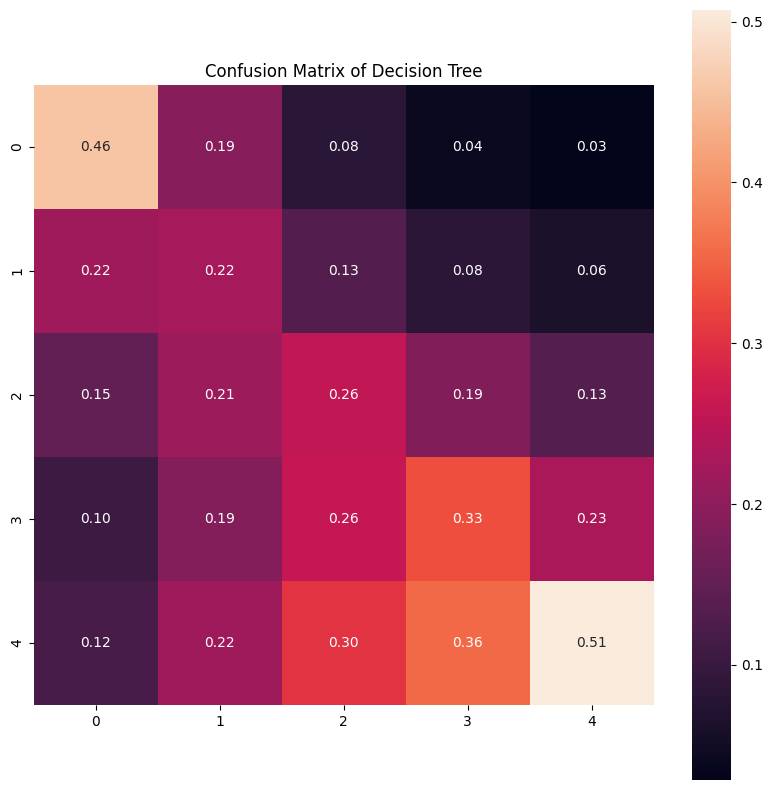

In [11]:
#决策树混淆矩阵可视化
con_mat1 = conf_matrix1 / conf_matrix1.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_mat1,annot=True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of Decision Tree")
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression

# 创建多分类逻辑回归模型
clf_2 = LogisticRegression(multi_class='multinomial')

# 训练模型
clf_2.fit(X_train, y_train)

# 使用训练好的模型进行预测
y_pred = clf_2.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy}")

# 打印分类报告（包括精确度、召回率和F1分数）
class_report = classification_report(y_test, y_pred)
print("分类报告:\n", class_report)

# 计算混淆矩阵
conf_matrix2 = confusion_matrix(y_test, y_pred)
print("混淆矩阵:\n", conf_matrix2)

d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


准确率: 0.36751323653875173
分类报告:
               precision    recall  f1-score   support

           1       0.52      0.07      0.13     15923
           2       0.23      0.01      0.02     17537
           3       0.15      0.00      0.00     27305
           4       0.27      0.00      0.00     36732
           5       0.37      0.99      0.54     54922

    accuracy                           0.37    152419
   macro avg       0.31      0.22      0.14    152419
weighted avg       0.30      0.37      0.21    152419

混淆矩阵:
 [[ 1174   406    87    13 14243]
 [  478   155    41    28 16835]
 [  240    72    31    62 26900]
 [  160    17    12    53 36490]
 [  217    21    38    43 54603]]


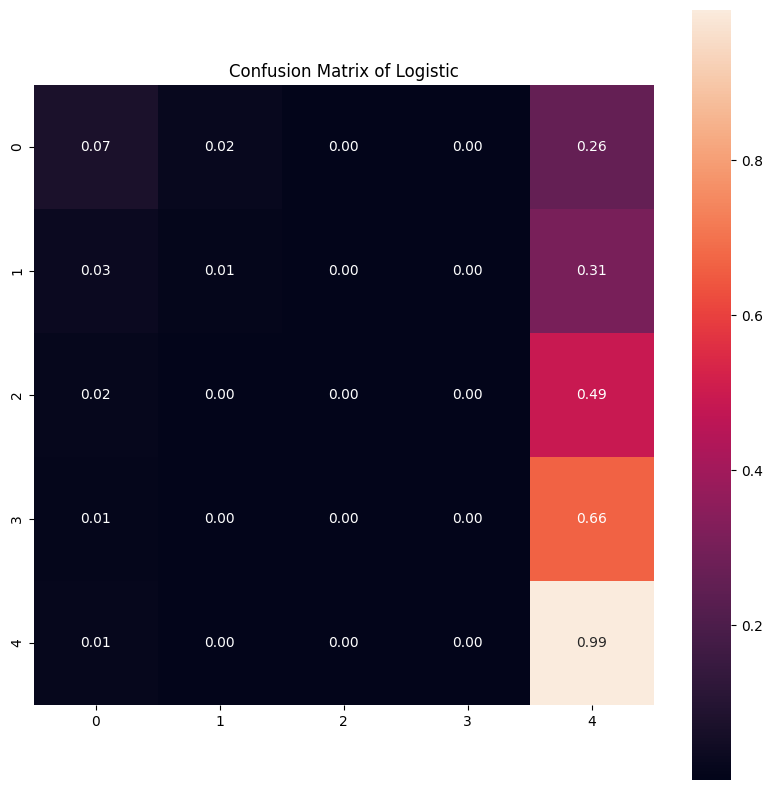

In [13]:
# 逻辑回归混淆矩阵
con_mat2 = conf_matrix2 / conf_matrix2.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_mat2, annot = True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of Logistic")
plt.show()

In [14]:
# 朴素贝叶斯
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

# 训练模型
nb_model.fit(X_train, y_train)

# 使用训练好的模型进行预测
y_pred = nb_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy}")

# 打印分类报告（包括精确度、召回率和F1分数）
class_report = classification_report(y_test, y_pred)
print("分类报告:\n", class_report)

# 计算混淆矩阵
conf_matrix3 = confusion_matrix(y_test, y_pred)
print("混淆矩阵:\n", conf_matrix3)

准确率: 0.4153681627618604
分类报告:
               precision    recall  f1-score   support

           1       0.51      0.45      0.48     15923
           2       0.21      0.11      0.14     17537
           3       0.25      0.09      0.13     27305
           4       0.32      0.09      0.14     36732
           5       0.44      0.88      0.59     54922

    accuracy                           0.42    152419
   macro avg       0.35      0.32      0.30    152419
weighted avg       0.36      0.42      0.34    152419

混淆矩阵:
 [[ 7239  2359  1945   506  3874]
 [ 3873  1887  1840  1125  8812]
 [ 1841  1738  2328  2550 18848]
 [  700  1390  1824  3408 29410]
 [  606  1506  1295  3067 48448]]


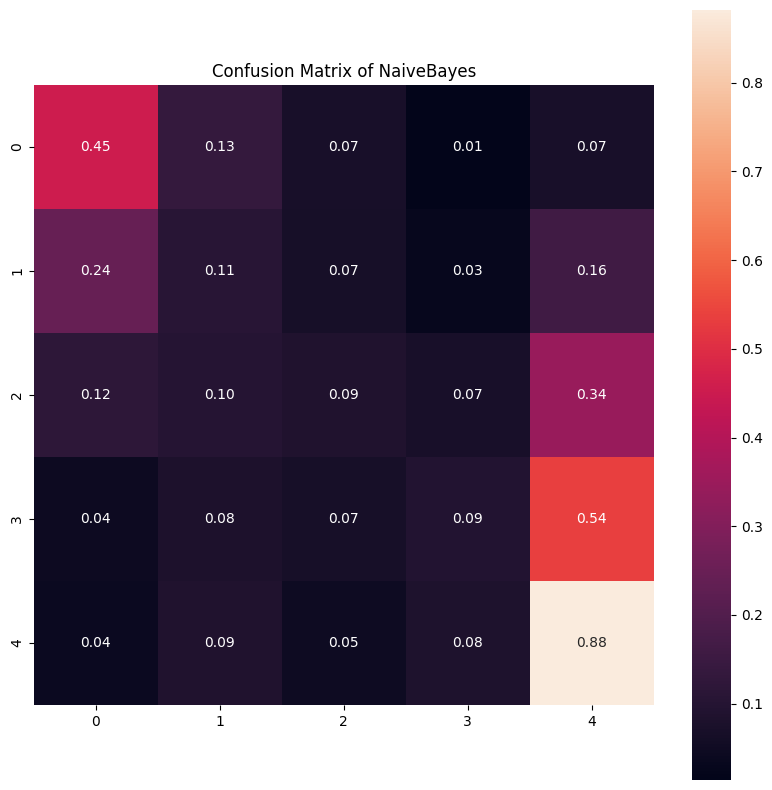

In [15]:
# 朴素贝叶斯混淆矩阵
con_mat3 = conf_matrix3 / conf_matrix3.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_mat3, annot = True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of NaiveBayes")
plt.show()

In [16]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier

clf_3 = RandomForestClassifier(n_estimators=300, random_state=42)

clf_3.fit(X_train,y_train)

y_pred = clf_3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy}")

class_report = classification_report(y_test, y_pred)
print("分类报告:\n", class_report)

conf_matrix4 = confusion_matrix(y_test, y_pred)
print("混淆矩阵:")
print(conf_matrix4)

准确率: 0.4316128566648515
分类报告:
               precision    recall  f1-score   support

           1       0.51      0.56      0.54     15923
           2       0.27      0.20      0.23     17537
           3       0.29      0.24      0.26     27305
           4       0.36      0.34      0.35     36732
           5       0.53      0.63      0.57     54922

    accuracy                           0.43    152419
   macro avg       0.39      0.39      0.39    152419
weighted avg       0.41      0.43      0.42    152419

混淆矩阵:
[[ 8944  2565  1526  1182  1706]
 [ 3812  3520  3192  2835  4178]
 [ 2172  2834  6460  6621  9218]
 [ 1176  1984  5553 12330 15689]
 [ 1286  2112  5594 11398 34532]]


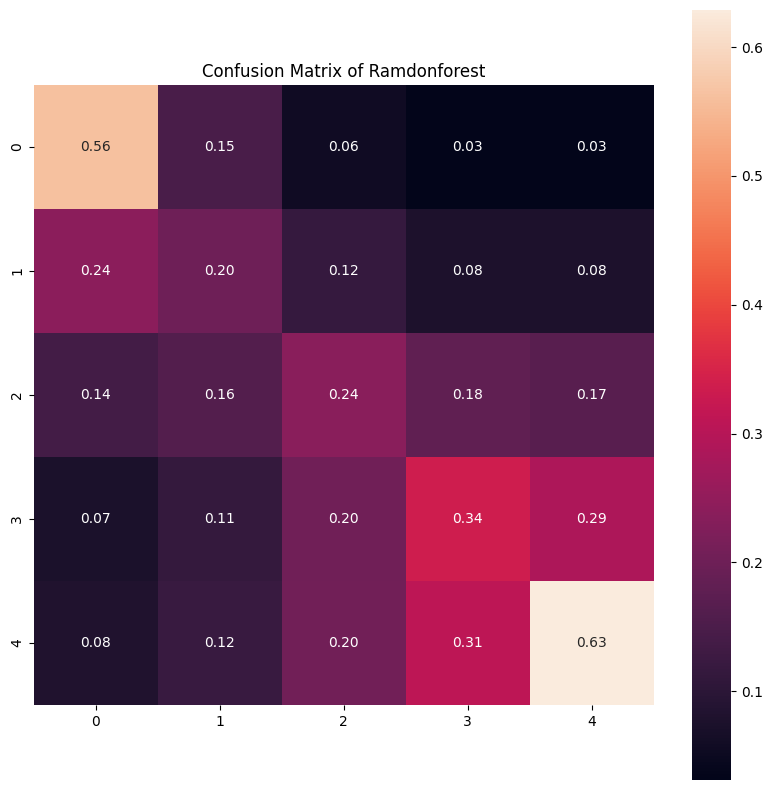

In [17]:
# 随机森林混淆矩阵
con_mat4 = conf_matrix4 / conf_matrix4.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_mat4, annot = True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of Ramdonforest")
plt.show()

In [18]:
feature_importances = clf_3.feature_importances_

importance_df = pd.DataFrame({'Feature': data_0.columns, 'Importance': feature_importances})

# 根据得分对特征进行排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                              Feature  Importance
56                                    height_div_area    0.139680
57                                     height_mul_are    0.139019
2                                   plinth_area_sq_ft    0.136930
47                                      age_mul_hight    0.085994
48                                     age_mul_floors    0.077948
1                                        age_building    0.075696
53                                  height_mul_mortar    0.030518
55                                   height_div_floor    0.027002
3                                    height_ft_pre_eq    0.025584
51                                     slope_mul_area    0.021775
6                 has_superstructure_mud_mortar_stone    0.020851
50                                      slope_mul_age    0.015850
11                          has_superstructure_timber    0.013514
18             foundation_type_Mud mortar-Stone/Brick    0.011082
49        

In [71]:
df_c = df.copy()

In [72]:
df_c['damage_grade'] = df_c['damage_grade'].replace({1: 1, 2: 2, 3: 2, 4: 3, 5: 3})

In [73]:
df_c

,district_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,age_mul_floors,slope_mul_hight,slope_mul_age,slope_mul_area,height_mul_cement,height_mul_mortar,height_mul_RC,height_div_floor,height_div_area,height_mul_are
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1,9,288,9,0,0,1,0,0,...,9,0,0,0,0,0,0,9.0,0.031250,2592
120101000021,12,1,15,364,9,0,0,1,0,0,...,15,0,0,0,0,0,0,9.0,0.024725,3276
120101000031,12,1,20,384,9,0,0,1,0,0,...,20,0,0,0,0,0,0,9.0,0.023438,3456
120101000041,12,1,20,312,9,0,0,1,0,0,...,20,0,0,0,0,0,0,9.0,0.028846,2808
120101000051,12,1,30,308,9,0,0,1,0,0,...,30,0,0,0,0,0,0,9.0,0.029221,2772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366709001241,36,2,60,165,18,0,0,1,0,0,...,120,0,0,0,0,18,0,9.0,0.109091,2970
366709001251,36,2,35,342,18,0,0,1,0,0,...,70,0,0,0,0,18,0,9.0,0.052632,6156
366709001261,36,2,35,342,18,0,0,1,0,0,...,70,0,0,0,0,18,0,9.0,0.052632,6156


In [74]:
data_c = df_c.drop(['district_id','damage_grade'],axis=1)
target_c = df_c['damage_grade']

In [81]:
from sklearn.ensemble import RandomForestClassifier

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_c, target_c, test_size=0.2, random_state=42)

clf_c = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=4,max_features=10)

clf_c.fit(X_train_c,y_train_c)

y_pred = clf_c.predict(X_test_c)

accuracy = accuracy_score(y_test_c, y_pred)
print(f"准确率: {accuracy}")

class_report = classification_report(y_test_c, y_pred)
print("分类报告:\n", class_report)

conf_matrix4 = confusion_matrix(y_test_c, y_pred)
print("混淆矩阵:")
print(conf_matrix4)

准确率: 0.6678891739218864
分类报告:
               precision    recall  f1-score   support

           1       0.62      0.34      0.44     15923
           2       0.48      0.19      0.27     44842
           3       0.70      0.96      0.81     91654

    accuracy                           0.67    152419
   macro avg       0.60      0.50      0.51    152419
weighted avg       0.63      0.67      0.61    152419

混淆矩阵:
[[ 5461  5623  4839]
 [ 2977  8393 33472]
 [  363  3346 87945]]


In [76]:
cluster1 = [12,20,31] # 31删掉
cluster2 = [21,24,30,36] 
cluster3 = [22,23,28,29]
df_c1=df_c[df_c['district_id'].isin(cluster1)]
df_c2=df_c[df_c['district_id'].isin(cluster2)]
df_c3=df_c[df_c['district_id'].isin(cluster3)]

In [77]:
data_c1 = df_c1.drop(['district_id','damage_grade'],axis=1)
target_c1 = df_c1['damage_grade']
data_c2 = df_c2.drop(['district_id','damage_grade'],axis=1)
target_c2 = df_c2['damage_grade']
data_c3 = df_c3.drop(['district_id','damage_grade'],axis=1)
target_c3 = df_c3['damage_grade']

In [100]:
X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(data_c1, target_c1, test_size=0.2, random_state=42)

In [101]:
from imblearn.over_sampling import SMOTE

# 创建SMOTE对象，可以根据需要调整参数
smote = SMOTE(sampling_strategy='auto', random_state=42)

# 对训练集进行重采样
X_train_c1, y_train_c1 = smote.fit_resample(X_train_c1, y_train_c1)
X_test_c1, y_test_c1 = smote.fit_resample(X_test_c1, y_test_c1)


In [102]:
from sklearn.ensemble import RandomForestClassifier



clf_c1 = RandomForestClassifier(n_estimators=200, random_state=42)

clf_c1.fit(X_train_c1,y_train_c1)

y_pred = clf_c1.predict(X_test_c1)

accuracy = accuracy_score(y_test_c1, y_pred)
print(f"准确率: {accuracy}")

class_report = classification_report(y_test_c1, y_pred)
print("分类报告:\n", class_report)

conf_matrixc1 = confusion_matrix(y_test_c1, y_pred)
print("混淆矩阵:")
print(conf_matrixc1)

准确率: 0.5976715067929959
分类报告:
               precision    recall  f1-score   support

           1       0.66      0.64      0.65     17837
           2       0.53      0.57      0.55     17837
           3       0.61      0.58      0.60     17837

    accuracy                           0.60     53511
   macro avg       0.60      0.60      0.60     53511
weighted avg       0.60      0.60      0.60     53511

混淆矩阵:
[[11455  3913  2469]
 [ 3525 10131  4181]
 [ 2252  5189 10396]]


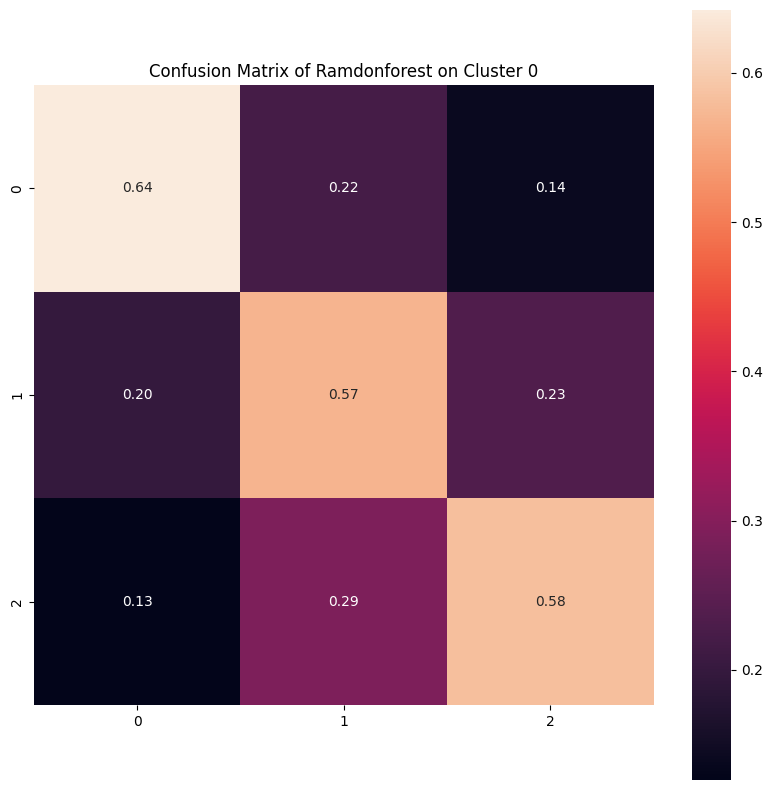

In [114]:
con_matc1 = conf_matrixc1 / conf_matrixc1.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_matc1, annot = True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of Ramdonforest on Cluster 0")
plt.show()

In [117]:
feature_importances = clf_c1.feature_importances_

importance_df = pd.DataFrame({'Feature': data_c1.columns, 'Importance': feature_importances})

# 根据得分对特征进行排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                              Feature  Importance
56                                    height_div_area    0.110549
57                                     height_mul_are    0.109680
2                                   plinth_area_sq_ft    0.106868
47                                      age_mul_hight    0.082865
48                                     age_mul_floors    0.069926
1                                        age_building    0.064415
6                 has_superstructure_mud_mortar_stone    0.045384
55                                   height_div_floor    0.042056
53                                  height_mul_mortar    0.035860
3                                    height_ft_pre_eq    0.034361
51                                     slope_mul_area    0.018003
27                               ground_floor_type_RC    0.017552
31                 other_floor_type_TImber/Bamboo-Mud    0.015478
22                 roof_type_Bamboo/Timber-Light roof    0.015394
11        

In [103]:
X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(data_c2, target_c2, test_size=0.2, random_state=42)

In [104]:
from imblearn.over_sampling import SMOTE

# 创建SMOTE对象，可以根据需要调整参数
smote = SMOTE(sampling_strategy='auto', random_state=42)

# 对训练集进行重采样
X_train_c2, y_train_c2 = smote.fit_resample(X_train_c2, y_train_c2)
X_test_c2, y_test_c2 = smote.fit_resample(X_test_c2, y_test_c2)


In [105]:
from sklearn.ensemble import RandomForestClassifier



clf_c2 = RandomForestClassifier(n_estimators=200, random_state=42)

clf_c2.fit(X_train_c2,y_train_c2)

y_pred = clf_c2.predict(X_test_c2)

accuracy = accuracy_score(y_test_c2, y_pred)
print(f"准确率: {accuracy}")

class_report = classification_report(y_test_c2, y_pred)
print("分类报告:\n", class_report)

conf_matrixc2 = confusion_matrix(y_test_c2, y_pred)
print("混淆矩阵:")
print(conf_matrixc2)

准确率: 0.7223670978848153
分类报告:
               precision    recall  f1-score   support

           1       0.88      0.82      0.85     39114
           2       0.61      0.57      0.59     39114
           3       0.69      0.78      0.73     39114

    accuracy                           0.72    117342
   macro avg       0.73      0.72      0.72    117342
weighted avg       0.73      0.72      0.72    117342

混淆矩阵:
[[32077  6134   903]
 [ 3992 22209 12913]
 [  337  8299 30478]]


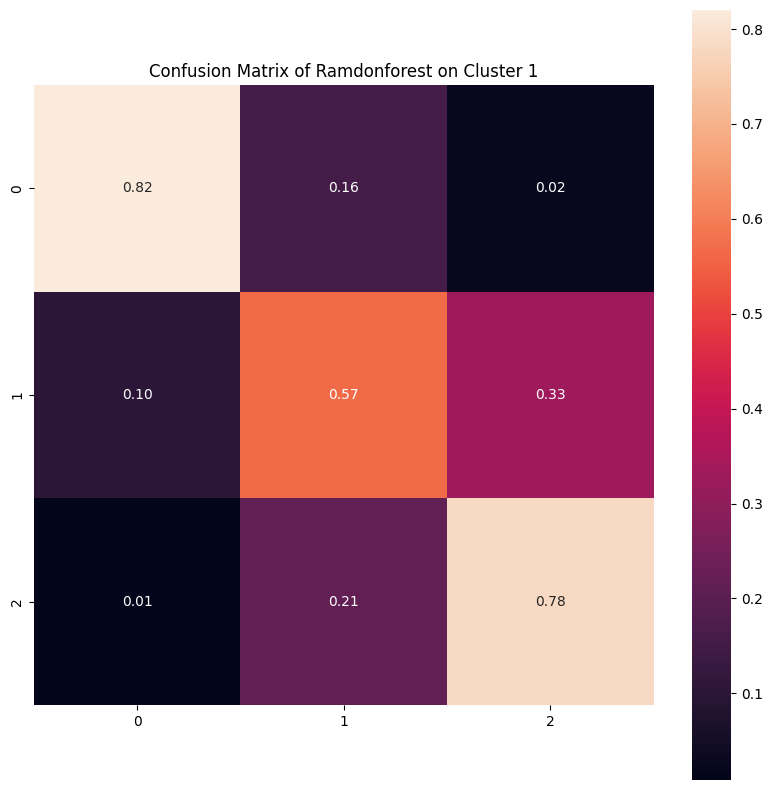

In [115]:
con_matc2 = conf_matrixc2 / conf_matrixc2.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_matc2, annot = True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of Ramdonforest on Cluster 1")
plt.show()

In [118]:
feature_importances = clf_c2.feature_importances_

importance_df = pd.DataFrame({'Feature': data_c2.columns, 'Importance': feature_importances})

# 根据得分对特征进行排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                              Feature  Importance
57                                     height_mul_are    0.086033
2                                   plinth_area_sq_ft    0.081784
56                                    height_div_area    0.080458
47                                      age_mul_hight    0.065007
6                 has_superstructure_mud_mortar_stone    0.064966
48                                     age_mul_floors    0.059074
53                                  height_mul_mortar    0.057560
1                                        age_building    0.052779
55                                   height_div_floor    0.038593
23                               roof_type_RCC/RB/RBC    0.038228
27                               ground_floor_type_RC    0.035167
20                                 foundation_type_RC    0.027013
3                                    height_ft_pre_eq    0.024670
54                                      height_mul_RC    0.022867
30        

In [106]:
X_train_c3, X_test_c3, y_train_c3, y_test_c3 = train_test_split(data_c3, target_c3, test_size=0.2, random_state=42)

In [108]:
from imblearn.over_sampling import SMOTE

# 创建SMOTE对象，可以根据需要调整参数
smote = SMOTE(sampling_strategy='auto', random_state=42)

# 对训练集进行重采样
X_train_c3, y_train_c3 = smote.fit_resample(X_train_c3, y_train_c3)
X_test_c3, y_test_c3 = smote.fit_resample(X_test_c3, y_test_c3)

In [109]:
from sklearn.ensemble import RandomForestClassifier


clf_c3 = RandomForestClassifier(n_estimators=200, random_state=42)

clf_c3.fit(X_train_c3,y_train_c3)

y_pred = clf_c3.predict(X_test_c3)

accuracy = accuracy_score(y_test_c3, y_pred)
print(f"准确率: {accuracy}")

class_report = classification_report(y_test_c3, y_pred)
print("分类报告:\n", class_report)

conf_matrixc3 = confusion_matrix(y_test_c3, y_pred)
print("混淆矩阵:")
print(conf_matrixc3)

准确率: 0.809661929163041
分类报告:
               precision    recall  f1-score   support

           1       0.86      0.73      0.79     41372
           2       0.71      0.75      0.73     41372
           3       0.87      0.95      0.91     41372

    accuracy                           0.81    124116
   macro avg       0.81      0.81      0.81    124116
weighted avg       0.81      0.81      0.81    124116

混淆矩阵:
[[30057 10883   432]
 [ 4652 31008  5712]
 [  172  1773 39427]]


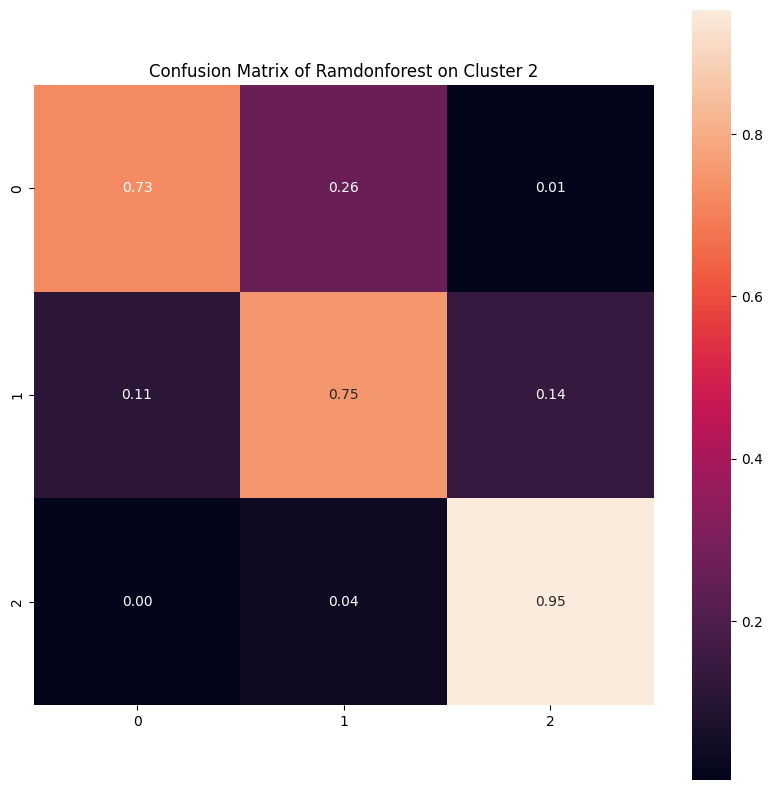

In [116]:
con_matc3 = conf_matrixc3 / conf_matrixc3.astype(float).sum(axis=1)
plt.figure(figsize = (10,10))
ax = sns.heatmap(con_matc3, annot = True,fmt='.2f', annot_kws={"size": 10},square= True)
plt.title("Confusion Matrix of Ramdonforest on Cluster 2")
plt.show()

In [119]:
feature_importances = clf_c3.feature_importances_

importance_df = pd.DataFrame({'Feature': data_c3.columns, 'Importance': feature_importances})

# 根据得分对特征进行排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                              Feature  Importance
6                 has_superstructure_mud_mortar_stone    0.075442
53                                  height_mul_mortar    0.068238
57                                     height_mul_are    0.066726
2                                   plinth_area_sq_ft    0.056419
56                                    height_div_area    0.055599
55                                   height_div_floor    0.052499
47                                      age_mul_hight    0.050489
48                                     age_mul_floors    0.047364
1                                        age_building    0.039129
27                               ground_floor_type_RC    0.032063
21                 roof_type_Bamboo/Timber-Heavy roof    0.031208
22                 roof_type_Bamboo/Timber-Light roof    0.029147
23                               roof_type_RCC/RB/RBC    0.028989
31                 other_floor_type_TImber/Bamboo-Mud    0.028633
33        